# Ferrari Performance over Time

In this part the performance of Ferrari will be investigated. The following questions should be answered:
1. How did the amount of Ferrari's wins develop?
3. How dependent are Ferrari's win on each drivers? # see possible spikes, compare if ever only constructors championship and not driver?
4. Did Ferrari's Qualifying results worsen?
5. Did Ferrari's Pit Stops improve?


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("F1") \
    .getOrCreate()

25/05/18 18:56:22 WARN Utils: Your hostname, bdlc-004 resolves to a loopback address: 127.0.1.1; using 10.176.129.6 instead (on interface ens192)
25/05/18 18:56:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/18 18:56:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/18 18:56:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/18 18:56:23 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/05/18 18:56:23 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/05/18 18:56:23 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
25/05/18 18:56:23 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045

# Preparation

In [122]:
results_df = spark.read.parquet(f"/f1/data/cleaned_results.parquet")
constructors_df = spark.read.parquet(f"/f1/data/cleaned_constructors.parquet")
drivers_df = spark.read.parquet(f"/f1/data/cleaned_drivers.parquet")
constructor_standings_df = spark.read.parquet(f"/f1/data/cleaned_constructor_standings.parquet")
races_df = spark.read.parquet(f"/f1/data/cleaned_races.parquet")
driver_standings_df = spark.read.parquet(f"/f1/data/cleaned_driver_standings.parquet")

In [123]:
ferrari = constructors_df.where(constructors_df.name == "Ferrari").select("constructorId").first().constructorId

# Ferrari Wins

1. How often did Ferrari drivers win a race in absolute numbers?
2. How often did Ferrari drivers win a race in relative numbers?
3. How often did Ferrari drivers win the championship?
4. How often did Ferrari win the constructor's championship?

## Ferrari Drivers Wins - Absolute Numbers

### Ferrari Driver Wins

To get the absolute numbers for the Ferrari wins of each year several preperations have to be done. Each step is in its own cell.

1. Get all winners of each race.
2. Get all Ferrari driver wins.
3. Get the absolute number of wins for Ferrari drivers each year.

In [124]:
first_places_df = results_df.join(drivers_df,
               results_df.driverId == drivers_df.driverId,
               "inner").join(races_df,
               races_df.raceId == results_df.raceId,
               "inner").where(results_df.position == 1)

In [125]:
ferrari_wins_df = first_places_df.where(first_places_df.constructorId == ferrari)

In [126]:
from pyspark.sql.functions import count

ferrari_wins_per_year_df = ferrari_wins_df.groupBy("year").agg(count('*').alias('wins')).sort("year")

### Other Drivers wins

To have more context, these numbers will also be compared to the average amount of wins for all teams. To have this data the following steps will be done:
1. Get the amount of wins per year for every team that is not Ferrari.
2. Get the average for the wins columns per year.

In [127]:
from pyspark.sql.functions import avg

others_wins_df = first_places_df.filter(first_places_df.constructorId != ferrari).groupBy("year", "constructorId").count().withColumnRenamed("count", "wins").orderBy("year", "wins", ascending=[True, False])

In [128]:
others_average_wins_df = others_wins_df.groupBy("year").agg(avg('wins').alias('wins')).sort("year")

### Difference

Out of the two previously created dataframes, an additional datagrame will be created that has all of that info and and additional column that hsows the difference between the Ferrari season wins and the Others season wins.

In [129]:
from pyspark.sql.functions import col, round as spark_round

others_df_renamed = others_average_wins_df.withColumnRenamed("wins", "others_wins")
ferrari_df_renamed = ferrari_wins_per_year_df.withColumnRenamed("wins", "ferrari_wins")

difference_df = (
    ferrari_df_renamed
    .join(others_df_renamed, on="year", how="inner")
    .withColumn("win_diff", col("ferrari_wins") - col("others_wins"))
    .orderBy("year")
)

difference_df.show()

+----+------------+------------------+-------------------+
|year|ferrari_wins|       others_wins|           win_diff|
+----+------------+------------------+-------------------+
|1951|           3|               3.0|                0.0|
|1952|           7|               1.0|                6.0|
|1953|           7|               1.0|                6.0|
|1954|           2|2.3333333333333335|-0.3333333333333335|
|1955|           1|               3.0|               -2.0|
|1956|           6|               1.5|                4.5|
|1958|           2|               3.0|               -1.0|
|1959|           2|2.3333333333333335|-0.3333333333333335|
|1960|           1|               3.0|               -2.0|
|1961|           5|               3.0|                2.0|
|1963|           1|               4.5|               -3.5|
|1964|           3|2.3333333333333335| 0.6666666666666665|
|1966|           2|              1.75|               0.25|
|1968|           1|3.6666666666666665|-2.666666666666666

### Comparing the three epochs

In this part the three defined epochs will be compared by showing the average of the values in each epoch.

In [130]:
from pyspark.sql.functions import when

df_with_periods = difference_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
grouped_by_period_df = df_with_periods.groupBy("period").agg(
    avg("ferrari_wins").alias("avg_ferrari_wins"),
    avg("others_wins").alias("avg_others_wins"),
    avg("win_diff").alias("avg_win_diff")
).orderBy("period")

print("\nAverage Values per Defined Period:")
grouped_by_period_df.show()


Average Values per Defined Period:
+--------------------+------------------+------------------+-------------------+
|              period|  avg_ferrari_wins|   avg_others_wins|       avg_win_diff|
+--------------------+------------------+------------------+-------------------+
|Early Years (1950...|2.9444444444444446|2.6620370370370368|0.28240740740740733|
|Mid Years (1975-1...|              3.65|               4.5|-0.8499999999999999|
|Recent Years (200...| 5.857142857142857| 6.939682539682541|-1.0825396825396827|
+--------------------+------------------+------------------+-------------------+



Based on this table it does seem like Ferrari drivers are winning less races nowadays. During the mid years they dropped below the average in have continue to drop even more in the recent year.

### Regression

In this part the slope for the regression line for the values for the win difference over the years is calculated.

In [131]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(difference_df.select("year", "win_diff")) \
                               .select(col("features"), col("win_diff").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of 'win_diff' with respect to 'year' is: {slope_value}")

25/05/28 20:45:49 WARN Instrumentation: [9dc77ac4] regParam is zero, which might cause numerical instability and overfitting.



The slope of 'win_diff' with respect to 'year' is: -0.06788054123603138


Just like the table with the epochs, this seems to incdicate Ferrari winning less races than they used to but the slope does not seem very severe.

### Visualisation

The last part of the absolute value aims to visualise the development over the years.

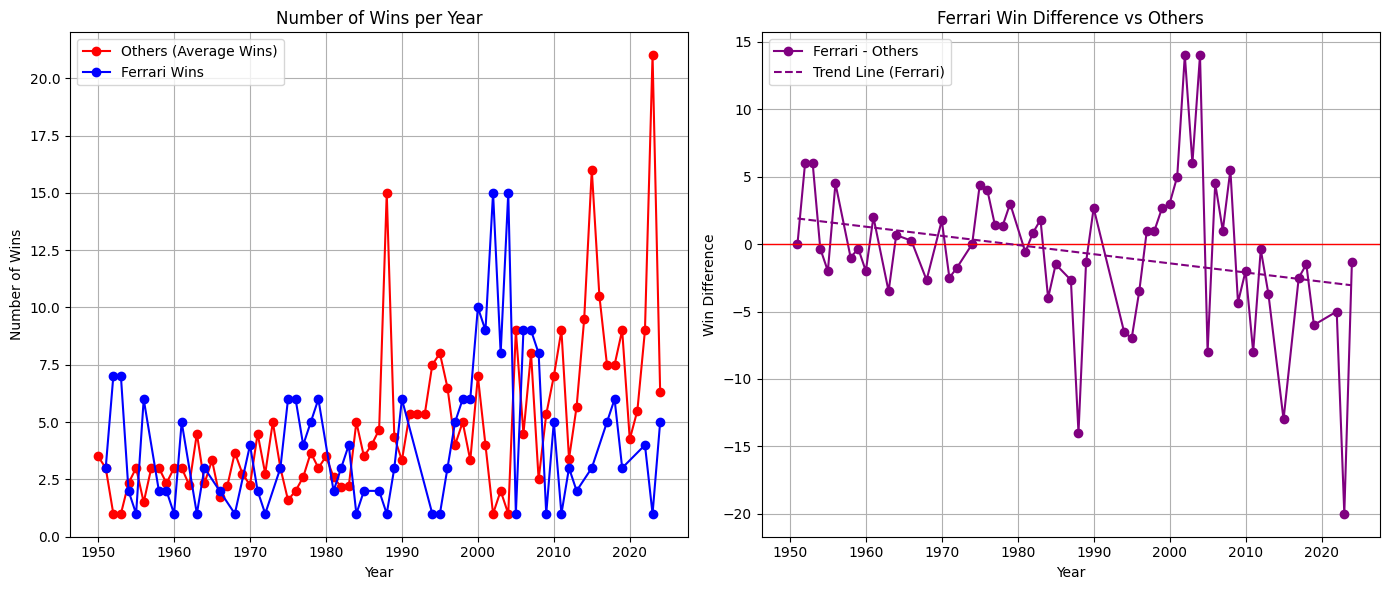

In [132]:
import matplotlib.pyplot as plt

others_average_wins_pdf = others_average_wins_df.toPandas()
ferrari_wins_per_year_pdf = ferrari_wins_per_year_df.toPandas()
difference_pdf = difference_df.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

axes[0].plot(
    others_average_wins_pdf['year'],
    others_average_wins_pdf['wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Others (Average Wins)'
)
axes[0].plot(
    ferrari_wins_per_year_pdf['year'],
    ferrari_wins_per_year_pdf['wins'],
    marker='o',
    color='blue',
    linestyle='-',
    label='Ferrari Wins'
)
axes[0].set_title('Number of Wins per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Wins')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(
    difference_pdf['year'],
    difference_pdf['win_diff'],
    marker='o',
    linestyle='-',
    color='purple',
    label='Ferrari - Others'
)
axes[1].axhline(y=0, color='red', linestyle='-', linewidth=1)
axes[1].set_title('Ferrari Win Difference vs Others')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Win Difference')

slope_value = lr_model.coefficients[0]
intercept_value = lr_model.intercept

years_for_plot = difference_pdf['year']
reg_line_predictions = [slope_value * yr + intercept_value for yr in years_for_plot]

axes[1].plot(
    years_for_plot,
    reg_line_predictions,
    color='purple',
    linestyle='--',
    label='Trend Line (Ferrari)'
)

axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

This visualisation supports the assumptions made based on the epoch table and the regression. Ferrari used to be either above or around average for several decade and started to drop a bit in the late 80s. While there was a point in the early 2000s where Ferrari drivers won a lot of races, since then they have been below average.

## Ferrari Drivers Wins - Relative Numbers

### Relative wins - Ferrari and Others

To compare the relative Numbers the following steps need to be done:

1. Get the amount of races per season.
2. Get the relative values of races that were won in a season by dividing the wins by the amount of races for Ferrari and the Other teams.

In [133]:
races_per_year = races_df.groupBy("year").agg(count('*').alias('races')).sort("year")

In [134]:
relative_ferrari_wins_df = (
    ferrari_wins_per_year_df
    .join(races_per_year, on="year", how="inner")
    .withColumn("relative_wins", col("wins") / col("races"))
    .orderBy("year")
)
relative_others_average_wins_df = (
    others_average_wins_df
    .join(races_per_year, on="year", how="inner")
    .withColumn("relative_wins", col("wins") / col("races"))
    .orderBy("year")
)

### Compare the three epochs

To see the development over the three defined epochs, get the average values for each epoch for the Ferrari wins.

In [135]:
df_with_periods = relative_ferrari_wins_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
grouped_by_period_df = df_with_periods.groupBy("period").agg(
    avg("relative_wins").alias("avg_ferrari_wins")
).orderBy("period")

print("\nAverage Values per Defined Period:")
grouped_by_period_df.show()


Average Values per Defined Period:
+--------------------+-------------------+
|              period|   avg_ferrari_wins|
+--------------------+-------------------+
|Early Years (1950...| 0.3194609402942736|
|Mid Years (1975-1...|0.23146533613445378|
|Recent Years (200...| 0.3219890242114922|
+--------------------+-------------------+



This table suggests that Ferrari drivers have been quite stable at winning races over the defined epochs, with a small dip in the mid years but overall stable based on these values.

### Regression

Get the slope for the regression lines for the relative wins of Ferrari over the years.

In [136]:
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(relative_ferrari_wins_df.select("year", "relative_wins")) \
                               .select(col("features"), col("relative_wins").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of relative numbers with respect to 'year' is: {slope_value}")

25/05/28 20:46:00 WARN Instrumentation: [f9954bee] regParam is zero, which might cause numerical instability and overfitting.



The slope of relative numbers with respect to 'year' is: -0.0015744710597113993


The regression slope also points to Ferrari drivers winning races pretty stably. The slope is a negative but not much.

### Visualisation

As a last the the development of the relative wins over time are visualisation.

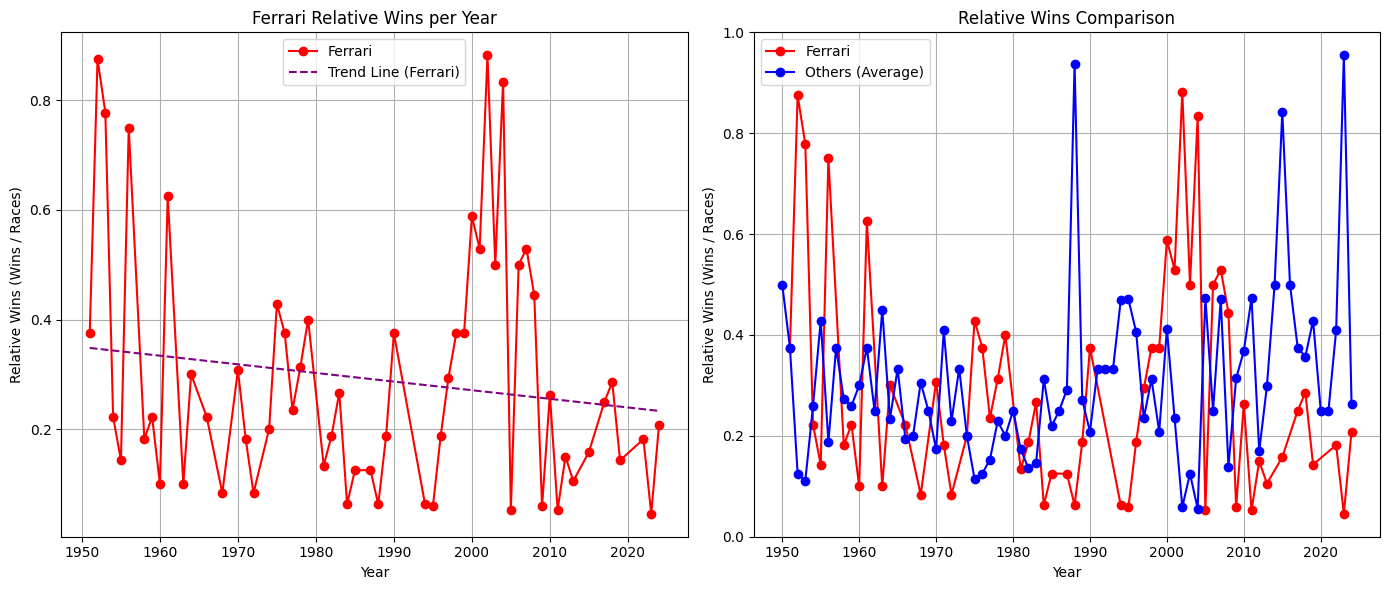

In [137]:
import matplotlib.pyplot as plt

ferrari_pdf = relative_ferrari_wins_df.toPandas()
others_pdf = relative_others_average_wins_df.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(
    ferrari_pdf['year'],
    ferrari_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Ferrari'
)
axes[0].set_title('Ferrari Relative Wins per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Relative Wins (Wins / Races)')

slope_value = lr_model.coefficients[0]
intercept_value = lr_model.intercept

years_for_plot = ferrari_pdf['year']
reg_line_predictions = [slope_value * yr + intercept_value for yr in years_for_plot]

axes[0].plot(
    years_for_plot,
    reg_line_predictions,
    color='purple',
    linestyle='--',
    label='Trend Line (Ferrari)'
)


axes[0].grid(True)
axes[0].legend()


axes[1].plot(
    ferrari_pdf['year'],
    ferrari_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Ferrari'
)
axes[1].plot(
    others_pdf['year'],
    others_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Others (Average)'
)
axes[1].set_title('Relative Wins Comparison')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Relative Wins (Wins / Races)')
axes[1].grid(True)
axes[1].legend()



plt.tight_layout()
plt.show()


In the visualisation is is more clear that also the relative wins have decreased over the years. The table of the epochs did show not a real decrease which is likely because of the successful period in the early 2000s. Without this time is would be more evident also in the previous sections that Ferrari startet out into Formula 1 very well and started winning less over time. This does not definitely mean that Ferrari got worse, it could also mean that other teams simply got better.

## Ferrari Drivers Championships

### Get Champions per season

To figure out who won the championship, the driver with the highest point in the last round of the season needs to be selected. To do this, the races dataset is partition by year to get the last round of each partition. The result is a dataframe that show for each year which driver won.

In [138]:
from pyspark.sql.window import Window
from pyspark.sql.functions import max, col

driver_standings_per_race = driver_standings_df.join(
    races_df,
    races_df.raceId == driver_standings_df.raceId,
    "inner"
)

window_by_year = Window.partitionBy("year")

with_max_round = driver_standings_per_race.withColumn(
    "max_round", max("round").over(window_by_year)
)

last_rounds_df = with_max_round.filter(col("round") == col("max_round")).drop("max_round")

driver_season_results_df = last_rounds_df.join(
    drivers_df,
    last_rounds_df.driverId == drivers_df.driverId,
    "inner"
).select(
    last_rounds_df.driverId,
    drivers_df.driverRef,
    last_rounds_df.year,
    driver_standings_df.position,
    driver_standings_df.points
).sort("year")
driver_champions_df = driver_season_results_df.where(driver_season_results_df.position == 1)

### Find Ferrari Drivers

1. Find all drivers that ever drove for a race for Ferrari
2. Get the two drivers per season that drove the most races
3. Create a dataframe that shows the timespan they drove for Ferrari for each Ferrari driver

In [139]:
ferrari_results_df = results_df.where(results_df.constructorId == ferrari).select("raceId", "driverId", "position")
ferrari_drivers_df = ferrari_results_df.join(drivers_df,
                                             drivers_df.driverId == ferrari_results_df.driverId,
                                             "inner").join(races_df,
                                             races_df.raceId == ferrari_results_df.raceId,
                                             "inner").select("position", "driverRef", "forename", "surname", "year", "date")

In the following step the dataframe is grouped so that only 2 drivers are listed per year. It is normal that every team has two drivers but sometimes a replacement driver needs to drive. To get meaningful results only the two main drivers will be shown. 

In [140]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, count

races_per_driver = ferrari_drivers_df.groupBy("year", "driverRef").agg(count("*").alias("race_count"))

window_spec = Window.partitionBy("year").orderBy(races_per_driver["race_count"].desc())
ranked = races_per_driver.withColumn("rank", row_number().over(window_spec))

top_2_per_year = ranked.filter("rank <= 2").select("year", "driverRef")
top_2_per_year.show(5)

+----+---------+
|year|driverRef|
+----+---------+
|1950|   ascari|
|1950|whitehead|
|1951|   ascari|
|1951|villoresi|
|1952|   farina|
+----+---------+
only showing top 5 rows



In [141]:
from pyspark.sql.functions import max, min

driver_span_df = top_2_per_year.groupBy("driverRef").agg(
    min("year").alias("startYear"),
    max("year").alias("endYear")
)

driver_span_df.show(5)

+----------+---------+-------+
| driverRef|startYear|endYear|
+----------+---------+-------+
|scarfiotti|     1967|   1967|
|     sainz|     2021|   2024|
|      ickx|     1968|   1973|
|    farina|     1952|   1955|
|      amon|     1967|   1969|
+----------+---------+-------+
only showing top 5 rows



In [142]:
ferrari_champions_df = driver_champions_df.join(
    driver_span_df,
    (driver_champions_df.driverRef == driver_span_df.driverRef) &
    (driver_champions_df.year >= driver_span_df.startYear) &
    (driver_champions_df.year <= driver_span_df.endYear),
    how='inner'
)
ferrari_champions_df = ferrari_champions_df.select(
    driver_champions_df.driverId,
    driver_champions_df.driverRef,
    driver_champions_df.year,
    driver_champions_df.position,
    driver_champions_df.points
)

### Compare the three epochs

The amount of championship wins per epoch will be compared.

In [143]:
from pyspark.sql.functions import sum

df_with_periods = ferrari_champions_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
grouped_by_period_df = df_with_periods.groupBy("period").agg(
    sum("position").alias("ferrari_wins")
).orderBy("period")

print("\Wins per Defined Period:")
grouped_by_period_df.show()

\Wins per Defined Period:
+--------------------+------------+
|              period|ferrari_wins|
+--------------------+------------+
|Early Years (1950...|           6|
|Mid Years (1975-1...|           3|
|Recent Years (200...|           6|
+--------------------+------------+



This table shows the same thing as the previous epoch table for the relative race wins. In recent years, Ferari won the same amount of driver's championship as in the early years and had a dip in the mid years.

### Visualisation

(Mis-)using a bardiagram it is visualised in which year Ferrari drivers won, who won and how far apart the championship wins are.

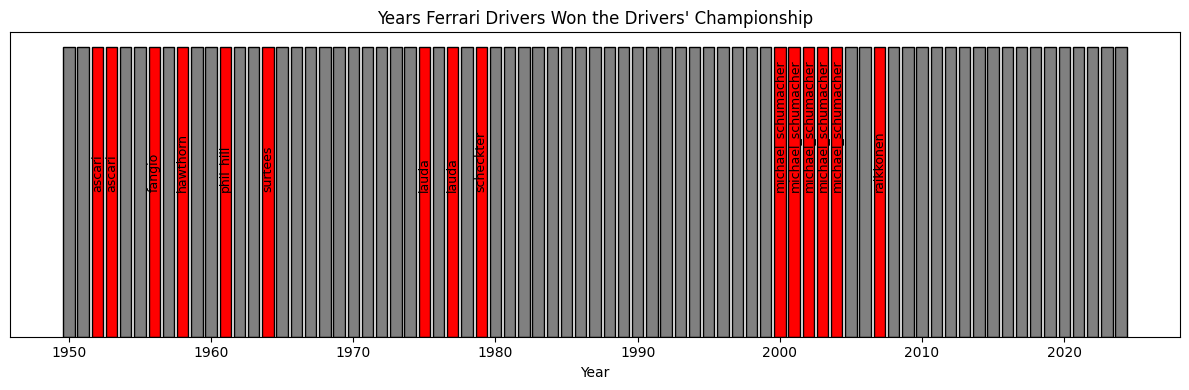

In [144]:
import matplotlib.pyplot as plt

driver_champions_pdf = driver_champions_df.toPandas()
ferrari_champions_pdf = ferrari_champions_df.toPandas()

driver_champions_pdf['is_ferrari'] = driver_champions_pdf['year'].isin(ferrari_champions_pdf['year'])

colors = ['red' if is_ferrari else 'gray' for is_ferrari in driver_champions_pdf['is_ferrari']]

plt.figure(figsize=(12, 4))
bars = plt.bar(driver_champions_pdf['year'], [1]*len(driver_champions_pdf), color=colors, edgecolor='black')

for i, row in driver_champions_pdf.iterrows():
    if row['is_ferrari']:
        plt.text(row['year'], 0.5, row['driverRef'], ha='center', va='bottom', fontsize=9, color='black', rotation=90)

plt.title('Years Ferrari Drivers Won the Drivers\' Championship')
plt.xlabel('Year')
plt.yticks([])
plt.tight_layout()
plt.show()

Copmaring the drivers championships over time based on this visualisation and the previous epochs table it does not seem like Ferrari has gotten significantly worse.

This visualisation shows a similar pattern as the relative wins visualisation: Ferrari started out really strong and in the early 2000s they dominated. Since the early 2000s it seems they were no longer on that level.

Comparing the championship break in the 80s and 90s and the one in the 2010s and 2020s it seems like Ferrari is now in a similar state as in the 80s and 90s.

All those things cannot be taken as a clear fact that Ferrari got worse. Over time more teams joined Formula 1 while in the early years there were much less teams.

What is noteworthy in this visualisation is that in the early years many different drivers won the championship, copmared to the recen years with one dirver winning 5 out of the 6 championships. 

## Ferrari Constructor Championship

### Absolute Numbers

Find out which teams won how many championships. For the constructor championships only the winner team of each season will be saved into the dataframe, as the points are not needed for any further research.

In [145]:
from pyspark.sql.window import Window
from pyspark.sql.functions import max


constructor_standings_per_race = constructor_standings_df.join(races_df,
               races_df.raceId == constructor_standings_df.raceId,
               "inner")

window_by_year = Window.partitionBy("year")

with_max_round = constructor_standings_per_race.withColumn(
    "max_round", max("round").over(window_by_year)
)

last_rounds_df = with_max_round.filter(col("round") == col("max_round")).drop("max_round")

constructor_season_results_df = last_rounds_df.join(constructors_df,
                                          last_rounds_df.constructorId == constructors_df.constructorId,
                                          "inner").select(last_rounds_df.constructorId, constructors_df.name, last_rounds_df.year, constructor_standings_df.position).sort("year")

constructor_wins_df = constructor_season_results_df.where(constructor_season_results_df.position == 1)

In [146]:
count_constructor_wins_df = constructor_wins_df.groupBy("name").agg(count('*').alias('wins')).sort("wins", ascending=False)
count_constructor_wins_df.show(20)

+-------------+----+
|         name|wins|
+-------------+----+
|      Ferrari|  16|
|     Williams|   9|
|      McLaren|   9|
|     Mercedes|   8|
|     Red Bull|   6|
|   Team Lotus|   4|
|Brabham-Repco|   2|
|      Renault|   2|
| Lotus-Climax|   2|
|Cooper-Climax|   2|
|     Benetton|   1|
|   Matra-Ford|   1|
|        Brawn|   1|
|          BRM|   1|
|      Tyrrell|   1|
|      Vanwall|   1|
|   Lotus-Ford|   1|
+-------------+----+



### Relative Numbers

Ferrari is a team that has been in Formula 1 for the longest time of any teams so it is important to see the relative values. To do that the total amount of seasons a team has participated in is collected and then the amount of wins per team is divided by this season amount.

In [147]:
count_races_per_constructor_df = constructor_season_results_df.groupBy("name").agg(count('*').alias('seasons')).sort("seasons", ascending=False)

In [148]:
constructors_wins_and_races_df = count_constructor_wins_df.join(count_races_per_constructor_df,
                                                                count_constructor_wins_df.name == count_races_per_constructor_df.name,
                                                                "inner").withColumn("rel_wins", col("wins") / col("seasons")).sort("rel_wins", ascending=False)
constructors_wins_and_races_df.show(17)

+-------------+----+-------------+-------+--------------------+
|         name|wins|         name|seasons|            rel_wins|
+-------------+----+-------------+-------+--------------------+
|        Brawn|   1|        Brawn|      1|                 1.0|
|     Mercedes|   8|     Mercedes|     15|  0.5333333333333333|
|   Matra-Ford|   1|   Matra-Ford|      2|                 0.5|
|Brabham-Repco|   2|Brabham-Repco|      4|                 0.5|
|      Vanwall|   1|      Vanwall|      3|  0.3333333333333333|
|     Red Bull|   6|     Red Bull|     20|                 0.3|
| Lotus-Climax|   2| Lotus-Climax|      7|  0.2857142857142857|
|      Ferrari|  16|      Ferrari|     67| 0.23880597014925373|
|Cooper-Climax|   2|Cooper-Climax|      9|  0.2222222222222222|
|     Williams|   9|     Williams|     49|  0.1836734693877551|
|   Lotus-Ford|   1|   Lotus-Ford|      6| 0.16666666666666666|
|      McLaren|   9|      McLaren|     55| 0.16363636363636364|
|   Team Lotus|   4|   Team Lotus|     2

### Compare the three epochs

The total amount of constructor championship wins for each epoch is displayed.

In [149]:
df_with_periods = constructor_wins_df.where(constructor_wins_df.name == "Ferrari").withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
grouped_by_period_df = df_with_periods.groupBy("period").agg(
    sum("position").alias("ferrari_wins")
).orderBy("period")

print("\Wins per Defined Period:")
grouped_by_period_df.show()

\Wins per Defined Period:
+--------------------+------------+
|              period|ferrari_wins|
+--------------------+------------+
|Early Years (1950...|           2|
|Mid Years (1975-1...|           7|
|Recent Years (200...|           7|
+--------------------+------------+



### Visualise

The constructor championship wins are visualised in a bardiagram.

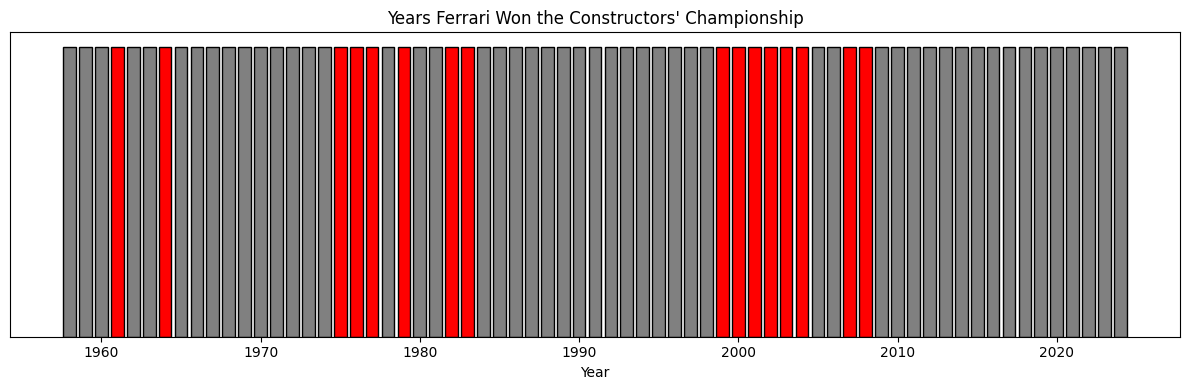

In [150]:
import matplotlib.pyplot as plt

constructor_wins_pdf = constructor_wins_df.toPandas()

constructor_wins_pdf['is_ferrari'] = constructor_wins_pdf['name'] == 'Ferrari'

colors = ['red' if is_ferrari else 'gray' for is_ferrari in constructor_wins_pdf['is_ferrari']]

plt.figure(figsize=(12, 4))
plt.bar(constructor_wins_pdf['year'], [1]*len(constructor_wins_pdf), color=colors, edgecolor='black')
plt.title('Years Ferrari Won the Constructors\' Championship')
plt.xlabel('Year')
plt.yticks([])
plt.tight_layout()
plt.show()

The constructor championship seems to not show a lot of development over the years. Ferrari seems to always have won several years and then taking a long time for another cluster to happen.

## Conclusion - Ferrari Wins

Based on the aboslute numbers of race wins it seems like Ferrari drivers are winning less racse nowadays. Over the threee epochs their win count has dropped continiously. This can also be supported by the regression slope as a number and when visualised. In the past Ferrari used to win above or around the average amount but the win count each year started to drop in the late 80s and since the early 2000s domination has been over they have continiously been winning below average.

The numbers for the relative numbers show a more stable image. While the number still have decreased overall it is not as strong. Some decrease is natural as more teams have joined Formula 1 over time. The decrease would likely be stronger had the 2000s domination not happend, apart from this big spike the numbers have decrease quite steadily. Despite the decrease they have been quite average until after the 2000s domination but after that the Ferrari relative wins and the average relative wins have cleary diverged.

All those things cannot be taken as a clear fact that Ferrari got worse. Over time more teams joined Formula 1 while in the early years there were much less teams and overall in recent years Formula 1 has tended to have strong dominations of a specific team for several years. Ferrari has been winning less over time so their standing as this very strong team is probably not quite accurate anymore based on wins alone while it was accurate in the beginning.

# Driver Dependencies

### Visualisation - Relative Race Wins with Drivers

One part of the investigation is to show the relative race wins of Ferrari and to see if big peaks coincide with one specific driver.

This section aims to show if Ferrari strongly depends on their strongest driver to win a constructors championship and if they over the years tended to have one very strong driver that carried the team or if both drivers were able to succeed. Both drivers being similarly good could indicate Ferrari being good as a whole team instead of "just" having a good driver.

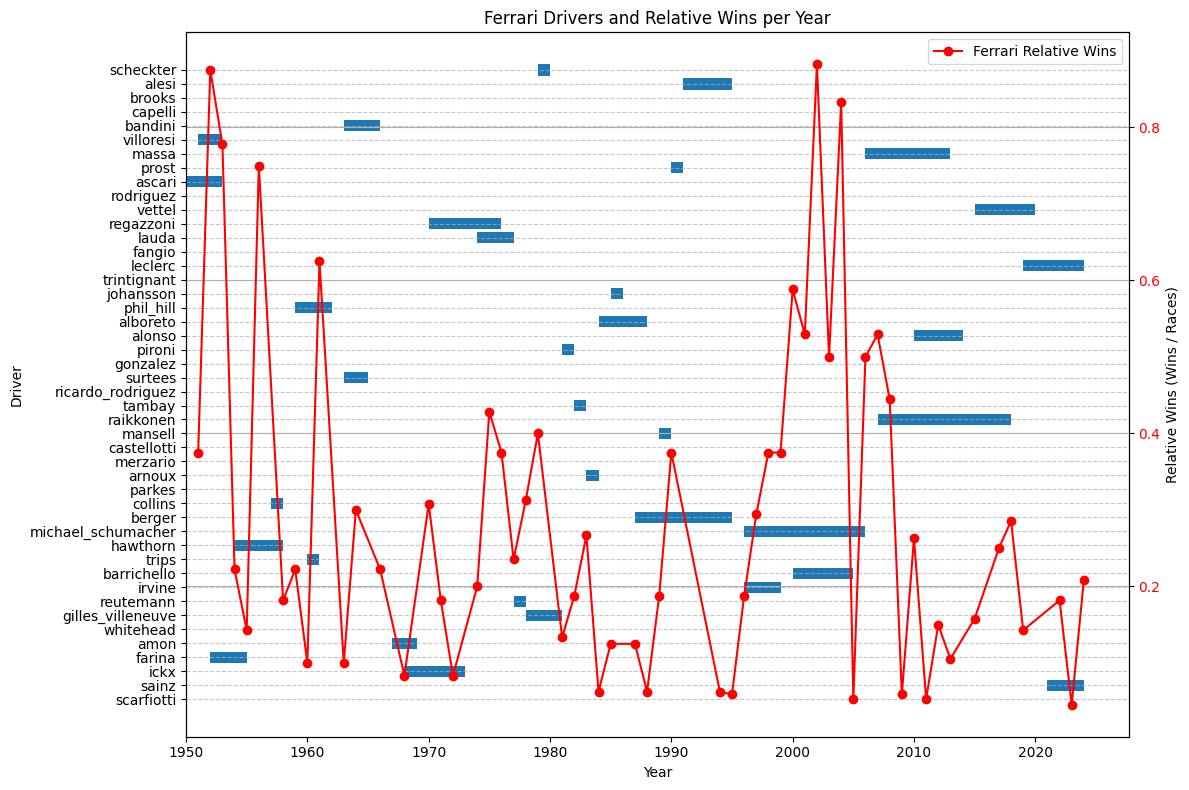

In [151]:
import matplotlib.pyplot as plt

driver_span_pdf = driver_span_df.toPandas()

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.barh(
    y=driver_span_pdf['driverRef'],
    width=driver_span_pdf['endYear'] - driver_span_pdf['startYear'],
    left=driver_span_pdf['startYear'],
)
ax1.set_xlabel('Year')
ax1.set_ylabel('Driver')
ax1.set_title('Ferrari Drivers and Relative Wins per Year')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(
    ferrari_pdf['year'],
    ferrari_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Ferrari Relative Wins'
)
ax2.set_ylabel('Relative Wins (Wins / Races)')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

The graphic should be read by looking at the peaks of the wins and see if the whole time on specific driver was driving keeping the peaks up. There is of course a relationship between drivers and wins but what shold be looked for are long peaks that coincide with one driver.

This long peak can be found in the 2000s during Michael Schumacher. Nothing as extreme can be seen in the graph to another time. So it does seem like Ferrari was good and had several good drivers in the past, then in the 2000s they had Michael Schumacher and apart from the time Kimi Raikkoen won the champtionship it seems they were never able to reach their previous levels again. This could mean that either the performance of the team itself has decreased or they have simply not been able to get good drivers. Considering the cult around Ferrari it seems like it is more likely that there have been shortcomings from the team itself.

### Investigate points per driver

In the next section the points of the Ferrari drivers will be compared with the maximum points reached in a season. To do that the following steps will be taken:
1. The maximum amount of points per season are collected
2. The 2 Ferrari drivers per year are joined with the maximum points
3. This dataframe will be joined with the results for each driver and the points the reached.
4. The Ferrari constructor championships are also used again.
5. All of these dataframes are joined

In [152]:
max_points_df = driver_season_results_df.groupBy("year").agg(
    max("points").alias("maxPoints")
)

In [153]:
top_2_with_max_points_df = top_2_per_year.join(
    max_points_df, 
    top_2_per_year.year == max_points_df.year, 
    "inner"
).select(top_2_per_year.year, top_2_per_year.driverRef, max_points_df.maxPoints)

In [154]:
top_2_with_points_df = top_2_with_max_points_df.join(
    driver_season_results_df,
    (top_2_with_max_points_df.year == driver_season_results_df.year) &
    (top_2_with_max_points_df.driverRef == driver_season_results_df.driverRef),
    "inner"
).select(
    top_2_with_max_points_df.year, 
    top_2_with_max_points_df.driverRef, 
    "maxPoints", 
    "position", 
    "points"
)

In [155]:
ferrari_constructor_wins_df = constructor_wins_df.where(constructor_wins_df.name == "Ferrari")

In [156]:
joined_df = top_2_with_points_df.join(
    ferrari_constructor_wins_df.select("year").withColumnRenamed("year", "ferrariWinYear"),
    top_2_with_points_df["year"] == col("ferrariWinYear"),
    "left"
)

result_with_ferrari_flag_df = joined_df.withColumn(
    "constructorChampionFerrari",
    col("ferrariWinYear").isNotNull()
).drop("ferrariWinYear")
result_with_ferrari_flag_df.sort("year").show(5)

+----+---------+---------+--------+------+--------------------------+
|year|driverRef|maxPoints|position|points|constructorChampionFerrari|
+----+---------+---------+--------+------+--------------------------+
|1950|whitehead|     30.0|       9|   4.0|                     false|
|1950|   ascari|     30.0|       5|  11.0|                     false|
|1951|villoresi|     31.0|       5|  15.0|                     false|
|1951|   ascari|     31.0|       2|  25.0|                     false|
|1952|   ascari|     36.0|       1|  36.0|                     false|
+----+---------+---------+--------+------+--------------------------+
only showing top 5 rows



### Visualisation

The points for each Ferrari driver and the maximum points of a season are plotted in the following section. It is also marked when Ferrari won the championship. This graph helps to see the difference between the two drivers and it helps to see whether Ferrari is able to win a constructor championship without a winning driver.

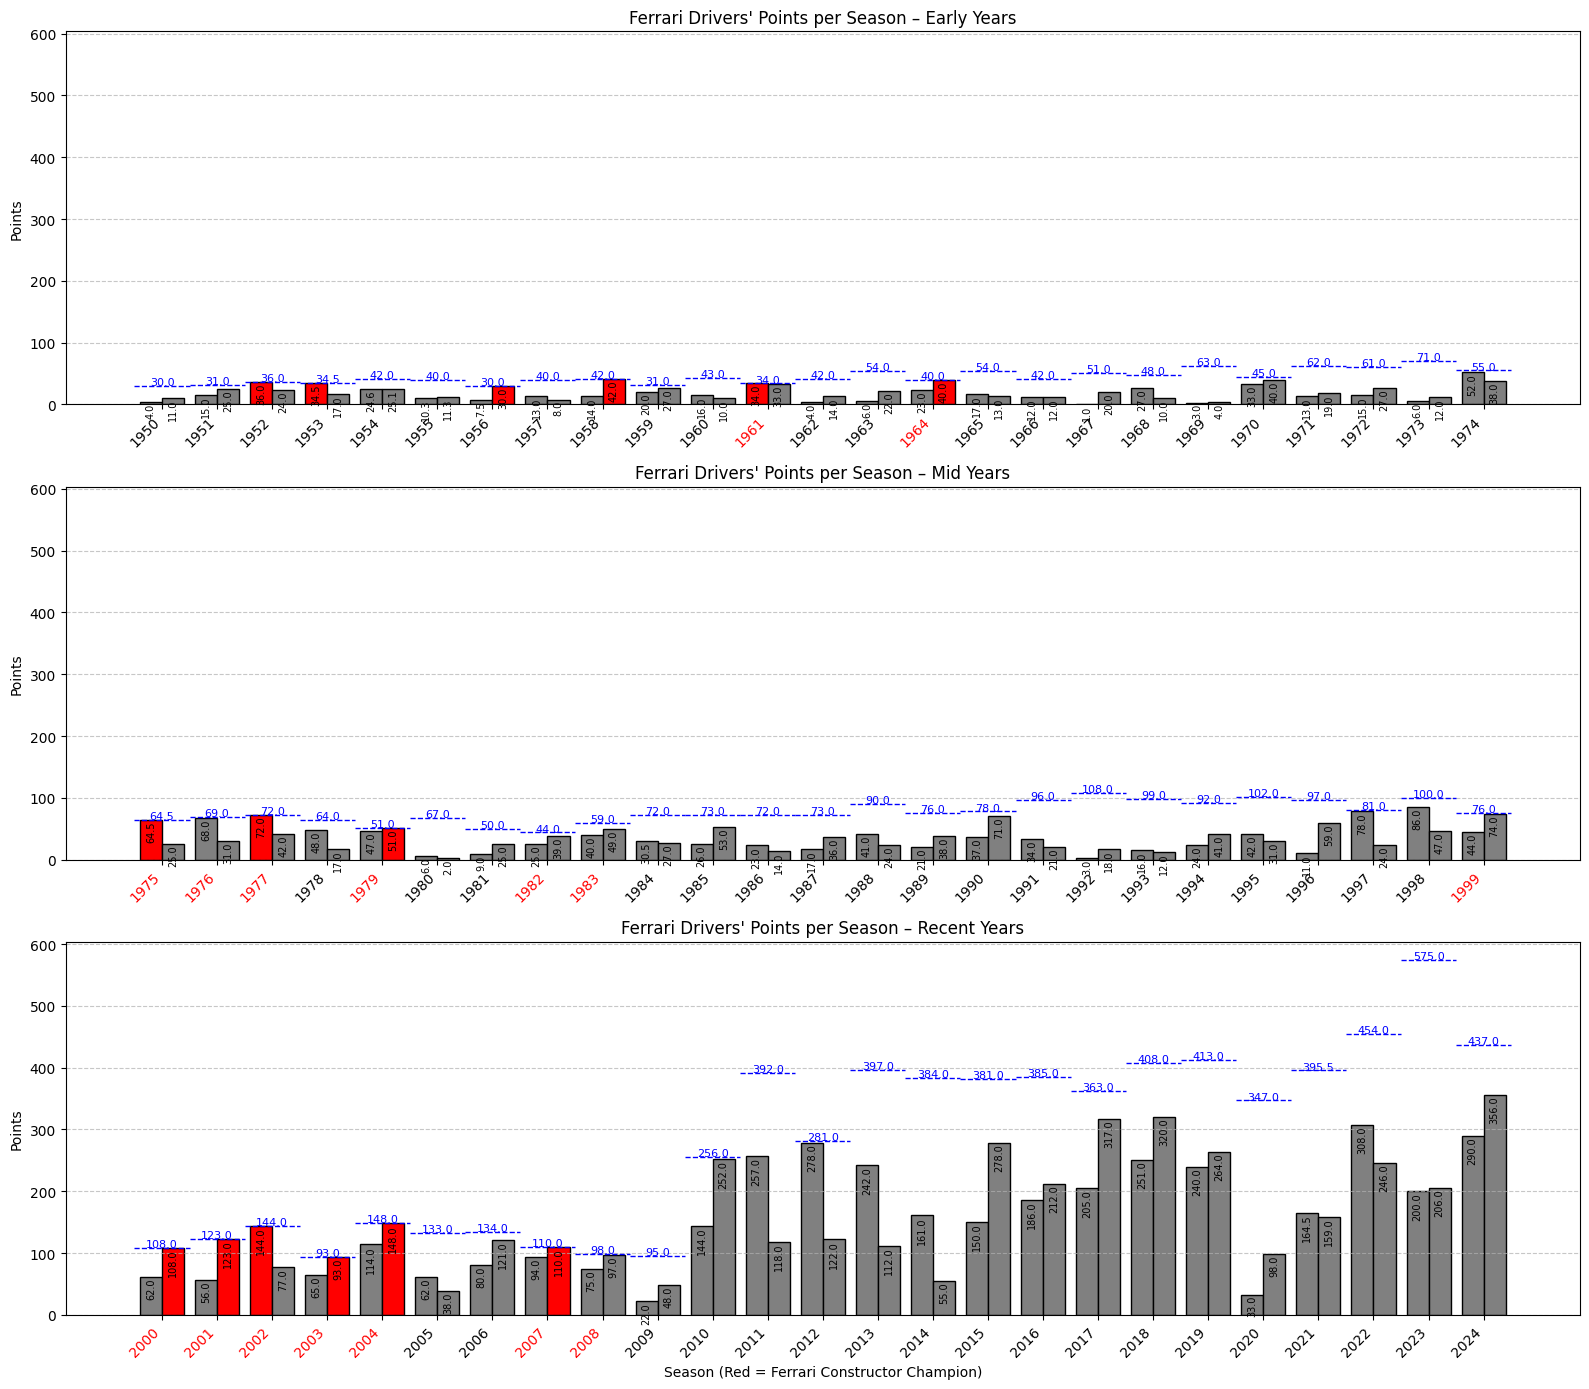

In [157]:
import matplotlib.pyplot as plt
import numpy as np

df = result_with_ferrari_flag_df.toPandas()

all_years = sorted(df["year"].unique())
n = len(all_years)
third = n // 3
chunks = [all_years[:third], all_years[third:2*third], all_years[2*third:]]

fig, axes = plt.subplots(3, 1, figsize=(16, 14), sharey=True)
bar_width = 0.4

for ax, years in zip(axes, chunks):
    x = np.arange(len(years))
    
    for i, year in enumerate(years):
        year_data = df[df["year"] == year].reset_index(drop=True)
        
        for j, row in year_data.iterrows():
            xpos = x[i] + (j - 0.5) * bar_width
            color = 'red' if row['position'] == 1 else 'gray'
            
            ax.bar(xpos, row['points'], width=bar_width, color=color, edgecolor='black')
                        
            ax.text(xpos, row['points'] - 1, f"{row['points']:.1f}", ha='center', va='top', fontsize=7, color='black', rotation=90)

        max_points = year_data["maxPoints"].iloc[0]
        ax.hlines(y=max_points, xmin=x[i] - 0.5, xmax=x[i] + 0.5, color='blue', linestyle='--', linewidth=1)
        ax.text(x[i], max_points + 1.5, max_points, ha='center', fontsize=8, color='blue')

    year_labels = []
    year_colors = []
    for year in years:
        won = df[(df["year"] == year)]["constructorChampionFerrari"].any()
        year_labels.append(str(year))
        year_colors.append('red' if won else 'black')

    ax.set_xticks(x)
    ax.set_xticklabels(year_labels, rotation=45, ha='right', color='black')
    
    for tick_label, color in zip(ax.get_xticklabels(), year_colors):
        tick_label.set_color(color)
    
    ax.set_ylabel("Points")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

axes[0].set_title("Ferrari Drivers' Points per Season – Early Years")
axes[1].set_title("Ferrari Drivers' Points per Season – Mid Years")
axes[2].set_title("Ferrari Drivers' Points per Season – Recent Years")
axes[2].set_xlabel("Season (Red = Ferrari Constructor Champion)")

plt.tight_layout()
plt.show()

Based on this graphic it seems that in the mid years they had the overall best perfroamnce as they won constructor championships without drivers winning the championship. In the recent years it seems that they have gotten further away from having a winning driver. There are years where it seems that Ferrari has two quite equal drivers but also years where there is a discrepency between the drivers. It is hard to see a pattern for that.

It is noteworthy that the amount of points per season have drastically increased especially after 2009. One reason for that is that there are more races per season nowadays and also the point system changed in 2009. This also means that the difference to the maximum points has naturally increased.

### Compare the three epochs

In the next section the average of the two Ferrari drivers, the points or the 'worse' Ferrari driver and those of the 'better' one will be compared for each epoch. This will be done in relative numbers, as the maximum points a driver can reach have been increasing a lot over the years and the point system has changed.

In [158]:
from pyspark.sql.functions import col, max, first

max_points_per_year_df = result_with_ferrari_flag_df.groupBy("year").agg(
    max("points").alias("max_driver_points"),
    first("maxPoints").alias("yearly_max_points")
)

avg_points_per_year_df = result_with_ferrari_flag_df.groupBy("year").agg(
    avg("points").alias("avg_driver_points"),
    first("maxPoints").alias("yearly_max_points")
)

min_points_per_year_df = result_with_ferrari_flag_df.groupBy("year").agg(
    min("points").alias("min_driver_points"),
    first("maxPoints").alias("yearly_max_points")
)

In [159]:
avg_percentage_df = avg_points_per_year_df.withColumn(
    "percentage_of_max",
    when(col("yearly_max_points") != 0, col("avg_driver_points") / col("yearly_max_points"))
    .otherwise(None)
).select("year", "percentage_of_max")


max_percentage_df = max_points_per_year_df.withColumn(
    "percentage_of_max",
    when(col("yearly_max_points") != 0, col("max_driver_points") / col("yearly_max_points"))
    .otherwise(None)
).select("year", "percentage_of_max")

min_percentage_df = min_points_per_year_df.withColumn(
    "percentage_of_max",
    when(col("yearly_max_points") != 0, col("min_driver_points") / col("yearly_max_points"))
    .otherwise(None)
).select("year", "percentage_of_max")

In [160]:
avg_df_with_periods = avg_percentage_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
avg_grouped_by_period_df = avg_df_with_periods.groupBy("period").agg(
    avg("percentage_of_max").alias("percentage_of_max")
).orderBy("period")

min_df_with_periods = min_percentage_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
min_grouped_by_period_df = min_df_with_periods.groupBy("period").agg(
    avg("percentage_of_max").alias("percentage_of_max")
).orderBy("period")

max_df_with_periods = max_percentage_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
max_grouped_by_period_df = max_df_with_periods.groupBy("period").agg(
    avg("percentage_of_max").alias("percentage_of_max")
).orderBy("period")


print("\Percentag of max points for max Ferrari driver points:")
max_grouped_by_period_df.show()

print("\Percentag of max points for average Ferrari driver points:")
avg_grouped_by_period_df.show()

print("\Percentag of max points for min Ferrari driver points:")
min_grouped_by_period_df.show()


\Percentag of max points for max Ferrari driver points:
+--------------------+------------------+
|              period| percentage_of_max|
+--------------------+------------------+
|Early Years (1950...|0.5893940529365199|
|Mid Years (1975-1...|0.6325895268238628|
|Recent Years (200...|0.7459663516004816|
+--------------------+------------------+

\Percentag of max points for average Ferrari driver points:
+--------------------+-------------------+
|              period|  percentage_of_max|
+--------------------+-------------------+
|Early Years (1950...| 0.4707145312316767|
|Mid Years (1975-1...|0.48890279578623735|
|Recent Years (200...| 0.6165580970361192|
+--------------------+-------------------+

\Percentag of max points for min Ferrari driver points:
+--------------------+-------------------+
|              period|  percentage_of_max|
+--------------------+-------------------+
|Early Years (1950...| 0.3520350095268336|
|Mid Years (1975-1...|0.34521606474861166|
|Recent Years (2

Based on these tables it seesm like the relative difference to the maximum points has increased for the better, the worse and both drivers together.

### Regression

For the values of the relative numbers of points the slope of a regression line is calcualted.

In [161]:
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(max_percentage_df.select("year", "percentage_of_max")) \
                               .select(col("features"), col("percentage_of_max").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of percentage to max points of average points: {slope_value}")

# AVG
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(avg_percentage_df.select("year", "percentage_of_max")) \
                               .select(col("features"), col("percentage_of_max").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of percentage to avg points of average points: {slope_value}")

# MIN
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(min_percentage_df.select("year", "percentage_of_max")) \
                               .select(col("features"), col("percentage_of_max").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of percentage to min points of average points: {slope_value}")

25/05/28 20:46:46 WARN Instrumentation: [64209c70] regParam is zero, which might cause numerical instability and overfitting.



The slope of percentage to max points of average points: 0.001216842631843129


25/05/28 20:46:47 WARN Instrumentation: [3951ef4e] regParam is zero, which might cause numerical instability and overfitting.



The slope of percentage to avg points of average points: 0.0014385064076291882


25/05/28 20:46:48 WARN Instrumentation: [c0c03628] regParam is zero, which might cause numerical instability and overfitting.



The slope of percentage to min points of average points: 0.0016601701834185073


The regression slope is showing a small rise in the points that Ferrari drivers are getting compared to the maximum points over all the years.

## Conclusion - Driver Dependency

Overall it seems like Ferrari has been more dependant on one specific driver to succes in recent years than they have been in the early years. This can be seen quite well with the big Michael Schumacher peak in the early 2000s compared to big peaks because of one driver not being that prelevant in the other epochs. Since Ferrari is a team with a very good image they are able to get very talented drivers but they were still never able to get as close to the maximum points after Michael Schumacher, which could point to shortcoming within the team itself.

In the mid years Ferrari was able to win constructor championships without a driver winning the championship aswell which is not really the case in the recent years anymore.

Based on the comparisons throught the three epochs it seesm like the relative difference to the maximum points has increased for the better, the worse and both drivers together, which means they have been getting less points compared to the maximum.

From this section it could be interpreted that in the recent year Ferrari has been more dependant on having an extraordinary driver to succeed and overall the performance of the team might have decreased. It could also be interpreted that after the Michael Schumacher era, another era for another team came. They were simply not the strongly dominating team anymore. When another team is dominating that strongly they also get very high maximum points which makes all the other points seem less and based on the previous data it seems like a team is nowadays able to dominate more strongly than in the earlier years which makes everyone else look worse.



# Qualifying

In this part of the investiagtion the Qualifying times over time will be investigated copmared to the qualifying times of the other teams. Only the times of Q3 will be used. Qualifying consists of three rounds, where Q3 is the last and only 10 drivers are left out of the 20. Here most drivers are trying their hardest as the standings of Q3 then define the starting positions so the data is the most accurate for the best performance. It is usual to have several times for the Q3 of one race.

In [162]:
qualifying_df = spark.read.parquet(f"/f1/data/cleaned_qualifying.parquet")

In [163]:
q3_df = qualifying_df.where((qualifying_df.q3 != "NULL") & (qualifying_df.q3 != "\\N")).select("raceId", "driverId", "constructorId", "position", "q3")

## Visualisation for time difference

As a first step the format of the time will be converted to a double showing the seoncds it took for a round so that this column is actually usable. And then the average of all the Q3 times per race is calculated. This will produce two dataframes:
1. Showing the general average
2. Showing the Ferrari average

These will then be combined and a column will be added that shows the difference between the general average and the Ferrari average. This will then be visualised.

In [164]:
from pyspark.sql.functions import col, unix_timestamp, split

df_with_seconds = q3_df.withColumn(
    "q3_seconds",
    split(col("q3"), ":").getItem(0).cast("int") * 60 + split(col("q3"), ":").getItem(1).cast("double")
)

avg_q3_df = df_with_seconds.groupBy("raceId").agg(
    (sum(col("q3_seconds")) / count(col("q3_seconds"))).alias("avg_q3_seconds")
)

In [165]:
qualifyings_with_race_df = races_df.join(
    avg_q3_df,
    "raceId",
    "inner").select(
    "raceId", "year", "name", "date", "quali_date", "avg_q3_seconds")

In [166]:
from pyspark.sql.functions import col, unix_timestamp, split

ferrari_q3_df = q3_df.where(q3_df.constructorId == ferrari)

ferrari_df_with_seconds = ferrari_q3_df.withColumn(
    "q3_seconds",
    split(col("q3"), ":").getItem(0).cast("int") * 60 + split(col("q3"), ":").getItem(1).cast("double")
)

avg_ferrari_q3_df = ferrari_df_with_seconds.groupBy("raceId").agg(
    (sum(col("q3_seconds")) / count(col("q3_seconds"))).alias("avg_q3_seconds")
)

In [167]:
ferrari_qualifyings_with_race_df = races_df.join(
    avg_ferrari_q3_df,
    "raceId",
    "inner").select(
    "raceId", "year", "name", "date", "quali_date", "avg_q3_seconds")

In [168]:
from pyspark.sql.functions import avg, col
from pyspark.sql.window import Window

ferrari_avg_q3_year = ferrari_qualifyings_with_race_df.groupBy("year").agg(
    avg("avg_q3_seconds").alias("ferrari_avg_q3")
).orderBy("year")

all_avg_q3_year = qualifyings_with_race_df.groupBy("year").agg(
    avg("avg_q3_seconds").alias("all_avg_q3")
).orderBy("year")

comparison_df = ferrari_avg_q3_year.join(all_avg_q3_year, "year", "inner")

comparison_with_diff_df = comparison_df.withColumn(
    "difference", col("ferrari_avg_q3") - col("all_avg_q3")
).orderBy("year")

comparison_with_diff_df.show(5)

+----+-----------------+-----------------+--------------------+
|year|   ferrari_avg_q3|       all_avg_q3|          difference|
+----+-----------------+-----------------+--------------------+
|2006|      82.98559375|83.32267530864198|-0.33708155864196954|
|2007|84.62247058823529|85.30241045751634|  -0.679939869281057|
|2008|87.58852777777777|88.03358827160494|-0.44506049382717094|
|2009|89.57876666666668|91.22785686274509| -1.6490901960784043|
|2010|          89.6495|90.92234736842106| -1.2728473684210542|
+----+-----------------+-----------------+--------------------+
only showing top 5 rows



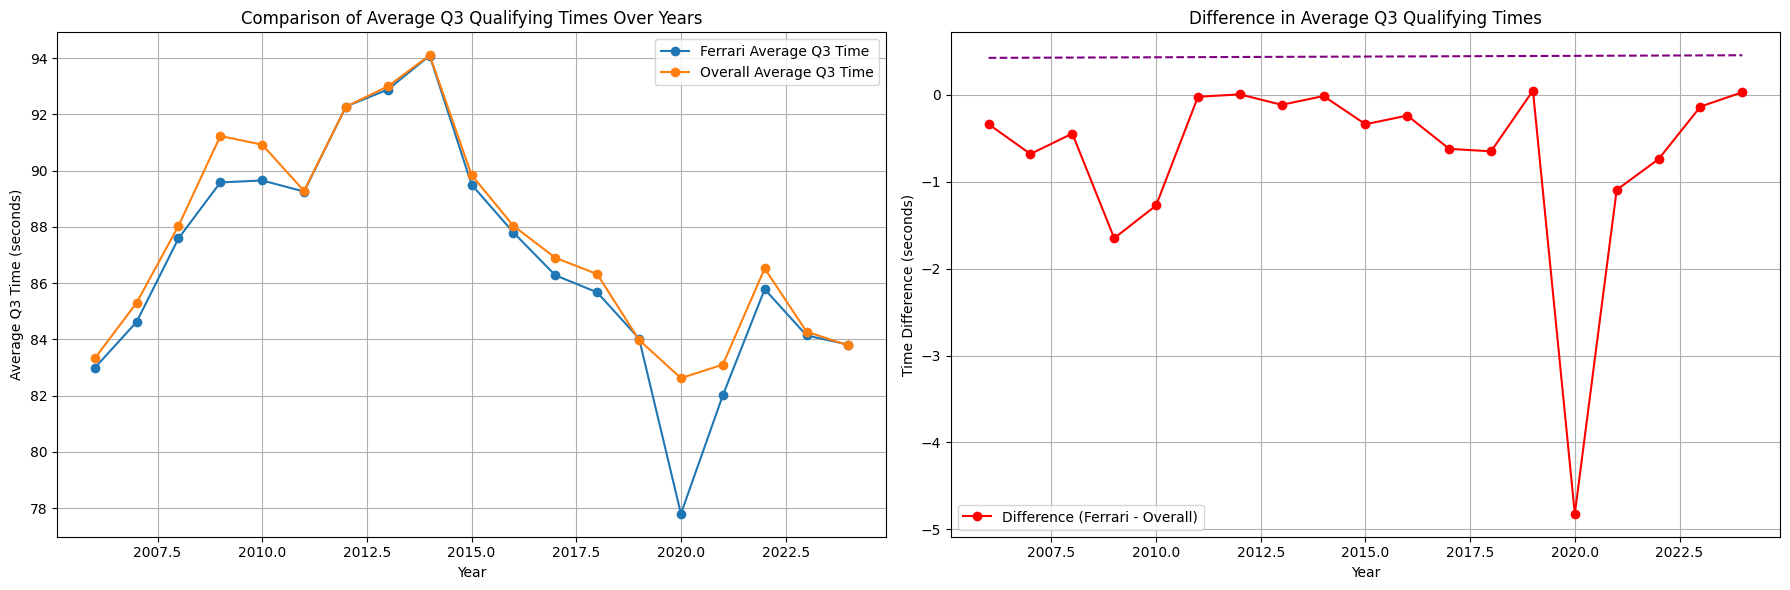

In [169]:
comparison_data = comparison_with_diff_df.collect()

years = [row.year for row in comparison_data]
avg_q3_ferrari = [row.ferrari_avg_q3 for row in comparison_data]
avg_q3_all = [row.all_avg_q3 for row in comparison_data]
difference = [row.difference for row in comparison_data]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

axes[0].plot(years, avg_q3_ferrari, label='Ferrari Average Q3 Time', marker='o')
axes[0].plot(years, avg_q3_all, label='Overall Average Q3 Time', marker='o')
axes[0].set_ylabel('Average Q3 Time (seconds)')
axes[0].set_title('Comparison of Average Q3 Qualifying Times Over Years')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Year')

axes[1].plot(years, difference, label='Difference (Ferrari - Overall)', color='red', marker='o')
axes[1].set_ylabel('Time Difference (seconds)')
axes[1].set_title('Difference in Average Q3 Qualifying Times')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Year')

slope_value = lr_model.coefficients[0]
intercept_value = lr_model.intercept

reg_line_predictions = [slope_value * yr + intercept_value for yr in years]

axes[1].plot(
    years,
    reg_line_predictions,
    color='purple',
    linestyle='--',
    label='Trend Line (Ferrari)'
)

plt.tight_layout()
plt.show()

Based on these visualisations Ferrari has always had quite a good performance concerning the qualifying. 2020 they seemed to have been really good. Likely 2020 was the time where they very oft had good results in qualifying but didn't actually win races based on the data from the previous sections. The difference is shown as decreasing, so Ferrari seems to be getting faster but this is most likely because of the drop in 2020. Without this they would likely be quite stable over time/

## Regression

The slope for the regression for the time difference over the years is calculated.

In [170]:
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(comparison_with_diff_df.select("year", "difference")) \
                               .select(col("features"), col("difference").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of qualifying time difference to the other team's average: {slope_value}")

25/05/28 20:47:01 WARN Instrumentation: [e766ca1f] regParam is zero, which might cause numerical instability and overfitting.



The slope of qualifying time difference to the other team's average: -0.020556506138624257


## Conclusion - Qualifying

Based on the visualisation and the regression slope Ferrari has improved a bit over the years compared to the others. This data is most likely not quite accurate as there is an outlier in 2020. Whithout this they would probably be quite stable over time concerning the Qualifying.

What is very important to note about this section is that this is only data from 2006 until 2024. So this does not display the whole history of Ferrari accuratly. It does show that they have been quite stable during this time.

# Pitstops

## Visualisation of time difference

Like for the Qualifying, the average value per race is calculated for all teams and for Ferrari. These are combined and then grouped by year and the differences between all teams and Ferrari are calculated and visualised over the years.

In [171]:
pit_stops_df = spark.read.parquet(f"/f1/data/cleaned_pit_stops.parquet")

In [172]:
average_pit_stop_duration_per_race_df = pit_stops_df.groupBy("raceId").agg(
    avg("milliseconds").alias("average_pit_stop_duration_ms")
)

In [173]:
ferrari_drivers_df = top_2_per_year.join(drivers_df, "driverRef", "inner") \
    .select("year", "driverId")

pit_stops_with_year_df = pit_stops_df.join(races_df, "raceId", "inner") \
    .select("raceId", "driverId", "year", "milliseconds")

ferrari_pit_stops_df = pit_stops_with_year_df.join(
    ferrari_drivers_df, ["year", "driverId"], "inner"
).select("raceId", "driverId", "milliseconds")

average_ferrari_pit_stop_duration_per_race_df = ferrari_pit_stops_df.groupBy("raceId").agg(
    avg("milliseconds").alias("average_ferrari_pit_stop_duration_ms")
)

In [174]:
all_avg_pit_stops_with_year_df = average_pit_stop_duration_per_race_df.join(
    races_df, "raceId", "inner"
).select("raceId", "average_pit_stop_duration_ms", "year")

ferrari_avg_pit_stops_with_year_df = average_ferrari_pit_stop_duration_per_race_df.join(
    races_df, "raceId", "inner"
).select("raceId", "average_ferrari_pit_stop_duration_ms", "year")

combined_avg_pit_stops_df = all_avg_pit_stops_with_year_df.join(
    ferrari_avg_pit_stops_with_year_df, ["raceId", "year"], "outer"
).select("raceId", "average_pit_stop_duration_ms", "average_ferrari_pit_stop_duration_ms", "year").sort("year")

In [175]:
yearly_avg_all_pit_stops_df = combined_avg_pit_stops_df.groupBy("year").agg(
    avg("average_pit_stop_duration_ms").alias("yearly_avg_all_pit_stop_duration_ms")
).orderBy("year")

yearly_avg_ferrari_pit_stops_df = combined_avg_pit_stops_df.groupBy("year").agg(
    avg("average_ferrari_pit_stop_duration_ms").alias("yearly_avg_ferrari_pit_stop_duration_ms")
).orderBy("year")

yearly_avg_pit_stops_comparison_df = yearly_avg_all_pit_stops_df.join(
    yearly_avg_ferrari_pit_stops_df, "year", "outer"
).orderBy("year")

yearly_avg_pit_stops_with_difference_df = yearly_avg_pit_stops_comparison_df.withColumn(
    "difference_ms",
    col("yearly_avg_ferrari_pit_stop_duration_ms") - col("yearly_avg_all_pit_stop_duration_ms")
)

yearly_avg_pit_stops_with_difference_df.show(5)

+----+-----------------------------------+---------------------------------------+-------------------+
|year|yearly_avg_all_pit_stop_duration_ms|yearly_avg_ferrari_pit_stop_duration_ms|      difference_ms|
+----+-----------------------------------+---------------------------------------+-------------------+
|2011|                   23272.8535376333|                      22877.09937343358| -395.7541641997195|
|2012|                  22998.14270007575|                     21990.991785714286| -1007.150914361464|
|2013|                 23643.918623029636|                     22623.966228070174|-1019.9523949594623|
|2014|                 25012.867466647673|                     24775.094736842104|-237.77272980556882|
|2015|                 25402.660099793637|                      25204.99956140351|-197.66053839012602|
+----+-----------------------------------+---------------------------------------+-------------------+
only showing top 5 rows



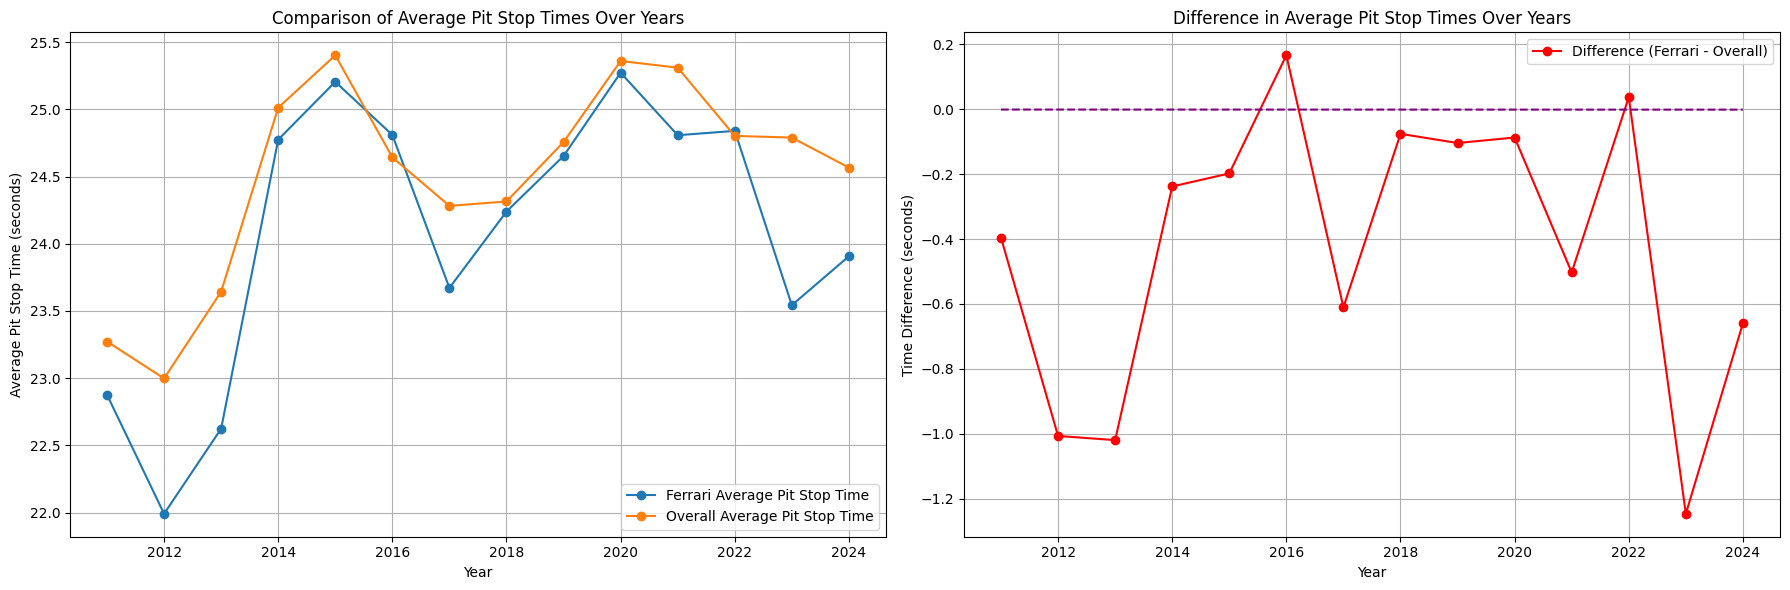

In [176]:
import matplotlib.pyplot as plt

yearly_pit_stop_data = yearly_avg_pit_stops_with_difference_df.collect()

years_pitstop = [row.year for row in yearly_pit_stop_data]
avg_pit_stop_all = [row.yearly_avg_all_pit_stop_duration_ms / 1000 if row.yearly_avg_all_pit_stop_duration_ms is not None else None for row in yearly_pit_stop_data] # Convert ms to seconds
avg_pit_stop_ferrari = [row.yearly_avg_ferrari_pit_stop_duration_ms / 1000 if row.yearly_avg_ferrari_pit_stop_duration_ms is not None else None for row in yearly_pit_stop_data] # Convert ms to seconds
difference_pitstop = [row.difference_ms / 1000 if row.difference_ms is not None else None for row in yearly_pit_stop_data]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

axes[0].plot(years_pitstop, avg_pit_stop_ferrari, label='Ferrari Average Pit Stop Time', marker='o')
axes[0].plot(years_pitstop, avg_pit_stop_all, label='Overall Average Pit Stop Time', marker='o')
axes[0].set_ylabel('Average Pit Stop Time (seconds)')
axes[0].set_title('Comparison of Average Pit Stop Times Over Years')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Year')

axes[1].plot(years_pitstop, difference_pitstop, label='Difference (Ferrari - Overall)', color='red', marker='o')
axes[1].set_ylabel('Time Difference (seconds)')
axes[1].set_title('Difference in Average Pit Stop Times Over Years')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Year')

slope_value = lr_model.coefficients[0]
intercept_value = lr_model.intercept
reg_line_predictions_seconds = [(slope_value * year + intercept_value) / 1000.0 for year in years_pitstop]
axes[1].plot(years_pitstop, reg_line_predictions_seconds, color='purple', linestyle='--')

plt.tight_layout()
plt.show()

## Regression

The slope of the regression for the values of the time difference over the years is calculated.

In [177]:
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(yearly_avg_pit_stops_with_difference_df.select("year", "difference_ms")) \
                               .select(col("features"), col("difference_ms").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of pit stops time compared to other teams: {slope_value}")

25/05/28 20:47:07 WARN Instrumentation: [626d3645] regParam is zero, which might cause numerical instability and overfitting.



The slope of pit stops time compared to other teams: 4.105822021293901


## Conclusion - Pit Stops

Based on the regression slope and the visualisation Ferrari has been taking longer to do pitstops. This is most likely because the whole time in the pit lane is collected and not just the actual part of changing the tyres and these pit lanes change their layout from time to time and the allowed speed has been reduced for safety reasons as well. Ferrari seems to be closer to the average nowadays then they used to be. This does not necessarlily mean that Ferrari's pitstops got worse but what it likely means is that most teams have been able to improve and the pitstops are now just quite similar in the time they can change the tyres.

There are additional factors that could prolong a pitstop. If the car is easily damaged they might have to switch out parts of it during the pitstops often or if a drivers scrapes the wall or has a light collision with another drivers if possible this also gets fixed during the pitstop. So it might be possible that in 2023 they had also other issues in the pitlane.

It is again important to note, this data is only from 2011 to 2024.

# Conclusion


Based on the aboslute numbers of race wins it seems like Ferrari drivers are winning less racse nowadays. In the past Ferrari used to win above or around the average amount but the win count each year started to drop in the late 80s and since the early 2000s domination has been over they have continiously been winning below average.

The numbers for the relative numbers show a more stable image. While the number still have decreased overall it is not as strong. Some decrease is natural as more teams have joined Formula 1 over time. The decrease would likely be stronger had the 2000s domination not happend. Despite the decrease they have been quite average until the 2000s domination but after that the Ferrari relative wins and the average relative wins have cleary diverged.

All those things cannot be taken as a clear fact that Ferrari got worse. Over time more teams joined Formula 1 while in the early years there were much less teams and overall in recent years Formula 1 has tended to have strong dominations of a specific team for several years. Ferrari has been winning less over time so their standing as this very strong team is probably not quite accurate anymore based on wins alone while it was accurate in the beginning.

Overall it seems like Ferrari has been more dependant on one specific driver to succeed in recent years than they have been in the early years. This can be seen quite well with the big Michael Schumacher peak in the early 2000s compared to big peaks because of one driver not being that prelevant in the other epochs. Since Ferrari is a team with a very good image they are able to get very talented drivers but they were still never able to get as close to the maximum points after Michael Schumacher, which could point to shortcoming within the team itself.

Based on the comparisons throught the three epochs it seesm like the relative difference to the maximum points has increased for the better, the worse and both drivers together, which means they have been getting less points compared to the maximum.

From this section it could be interpreted that in the recent year Ferrari has been more dependent on having an extraordinary driver to succeed and overall the performance of the team might have decreased. It could also be interpreted that after the Michael Schumacher era, another era for another team came. They were simply not the strongly dominating team anymore. When another team is dominating that strongly they also get very high maximum points which makes all the other points seem less and based on the previous data it seems like a team is nowadays able to dominate more strongly than in the earlier years which makes everyone else look worse.

The Qualifying shows that Ferrari over the years has been quite stable in their performance at least over one lap.

There is not much of a conclusion that can be made from the data about the pitstops about the overall Ferrari performance over time.

# How has Ferrari's Performance developed over time?

It seems that Ferrari has had a very strong start into Formula 1 based on their wins and dominated. As more teams joined this domination has decreased as have their wins. They had in the early 2000s another instance of strong domination thanks to Michael Schumacher but after that they again could not reach the levels of other possibly dominating teams. So it seems like compared to other teams, Ferrari's performance, aside from their qualifying times, has decreased. It is not clear based on the data whether that is due to issue on the Ferrari side or whether other teams are just really good and are thus outperforming Ferrari.